In [1]:
import numpy as np
import scipy 
from scipy import stats
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import pdb
import seaborn as sns
import pandas as pd
# plt.rcParams['figure.figsize'] = (15,10)
sns.set()

In [13]:
plt.rcParams['figure.figsize'] = (8,5)

In [3]:
Power = np.array([36.63, 38.26, 39.39, 40.56, 43.23, 56.54, 72.70, 84.19, 76.06, 61.32, 50.75, 46.90])
Gas = np.array([2.905, 2.81, 2.76, 2.73, 3.20, 3.88, 4.45, 4.8, 4.56, 4.13, 3.68, 3.49])
month_list = [i for i in range(1,13)] 
theta_po = [39.28, 40.65, 40.48, 42.75, 46.62, 71.88, 86.92, 103.63, 60.78, 35.55, 39.67, 44.47]
theta_ga = [2.51, 2.49, 2.66, 2.59, 5.28, 6.33, 6.39, 5.93, 3.12, 2.73, 2.02, 3.07]
Power = np.array([36.63, 38.26, 39.39, 40.56, 43.23, 56.54, 72.70, 84.19, 76.06, 61.32, 50.75, 46.90])
Gas = np.array([2.905, 2.81, 2.76, 2.73, 3.20, 3.88, 4.45, 4.8, 4.56, 4.13, 3.68, 3.49])
dt = 1/48
multiplier = np.arange(0.5, 1.52, 0.02)

In [19]:
def sen_test(eval_para_pos, PowerPrices = Power, GasPrices = Gas, thetap1= theta_po, thetag1 = theta_ga,
             n = 15000):
    #params
    N_month = 12
    N = 12
    N *= 4
    p_theta_std = np.array([1.45, 1.92, 2.36, 2.65, 5.01, 8.66, 12.21, 13.79, 12.78, 14.01, 12.77, 10.9])
    g_theta_std = np.array([0.17, 0.2, 0.28, 0.4, 0.43, 0.67, 0.48, 0.53, 0.45, 0.78, 0.84, 0.71])
    variable_list = [7, 20, 3, 75, 0.083, 35, 0, 3, 75, 7.22, 0.3, 28.87, 10.83, np.array(thetap1), np.array(thetag1)]
    variables_names = ['alphaCC', 'alphaJC', 'alphaG', 
                       'spike_mean', 'p', 'CC0', 'JC0', 'G0',
                       'spike_thres', 'sigmaG', 'rho', 
                       'v_summer', 'v_winter', 'PowerTheta', 'GasTheta']
    vec_res_p = list()
    vec_res_g = list()
    num_se = 3
    
    if eval_para_pos == 3:
        new_variable = np.array([75 - num_se * 5, 75, 75 + num_se * 5])
    elif eval_para_pos == 4:
        new_variable = np.array([0.083 - num_se * 0.005, 0.083, 0.083 + num_se * 0.005])
    elif eval_para_pos == 9:
        new_variable = np.array([7.22 - num_se * 0.05, 7.22, 7.22 + num_se * 0.05]) / np.sqrt(dt) / 100
    elif eval_para_pos == 10:
        new_variable = np.array([0.3 - num_se * 0.05, 0.3, 0.3 + num_se * 0.05])    
    elif eval_para_pos == 11:
        new_variable = np.array([28.87 - num_se * 2, 28.87, 28.87 + num_se * 2]) / np.sqrt(dt) / 100
    elif eval_para_pos == 12:
        new_variable = np.array([10.83 - num_se * 2, 10.83, 10.83 + num_se * 2]) / np.sqrt(dt) / 100
    elif eval_para_pos == 13:
        new_variable = np.array([variable_list[13] - num_se * p_theta_std, 
                                 variable_list[13],
                                 variable_list[13] + num_se * p_theta_std])
    elif eval_para_pos == 14:
        new_variable = np.array([variable_list[14] - num_se * g_theta_std, 
                                 variable_list[14],
                                 variable_list[14] + num_se * g_theta_std])
    
    for ix in range(len(new_variable)):
        variable_list[eval_para_pos] = new_variable[ix]
        alphaCC  = variable_list[0]
        alphaJC  = variable_list[1]
        alphaG  = variable_list[2]
        m  = variable_list[3]
        p  = variable_list[4]
        CC0  = variable_list[5]
        JC0  = variable_list[6]
        G0  = variable_list[7]
        spike_thres  = variable_list[8]
        sigmaG  = variable_list[9]/np.sqrt(dt)/100
        rho  = variable_list[10]
        v_summer  = variable_list[11]/np.sqrt(dt)/100
        v_winter  = variable_list[12]/np.sqrt(dt)/100
        PowerTheta  = variable_list[13]
        GasTheta  = variable_list[14]

        V = np.zeros((N+1,n))
        W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
        Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
        B = rho*W + np.sqrt(1-rho**2)*Wtilde

        CC = np.zeros((N+1,n)) 
        CC[0,:] = CC0
        JC = np.zeros((N+1,n))
        JC[0,:] = JC0
        G = np.zeros((N+1,n)) 
        G[0,:] = G0
        PC = np.zeros((N+1,n))
        PC[0,:] = CC[0,:]
        Power_MSE,Gas_MSE = 0, 0
        Power_Price_Fit, Gas_Price_Fit, CC_Price_Fit, JC_Price_Fit = list(), list(), list(), list()


        for i in range(1, N + 1):
            month1 = month_list[int(np.ceil(i/4)) - 1]    
            monthIndicator = (month1 > 4)&(month1 < 9)

            V[i,:] = monthIndicator*v_summer + (1 - monthIndicator)*v_winter
            CC[i,:] = alphaCC*(thetap1[month1-1] - CC[i-1,:])*dt + V[i,:]*CC[i-1,:]*W[i,:] + CC[i-1,:]
            JC[i,:] = alphaJC*( 0 - JC[i-1,:])*dt + m*(uniform.rvs() < p)+JC[i-1,:]
            #Power Price
            PC[i,:] = CC[i,:] + JC[i,:]*(PC[i-1,:] > spike_thres)
            #Gas Price
            G[i,:]  = alphaG*(thetag1[month1-1] - G[i-1,:])*dt + sigmaG * G[i-1,:] * B[i,:] + G[i-1,:]

            Power_MSE += np.abs(np.mean(PC[i,:]) - PowerPrices[month1 - 1])
            Gas_MSE += np.abs(np.mean(G[i,:]) - GasPrices[month1 - 1])
            
            if i%4 == 0:
                Power_Price_Fit.append(np.mean(PC[i,:]))
                Gas_Price_Fit.append(np.mean(G[i,:]))
                CC_Price_Fit.append(np.mean(CC[i,:]))
                JC_Price_Fit.append(np.mean(JC[i,:]))
#         MSE_p[ix] = Power_MSE
#         MSE_g[ix] = Gas_MSE
        
        vec_res_p.append(Power_Price_Fit)
        vec_res_g.append(Gas_Price_Fit)
        
    power_lines = pd.DataFrame(vec_res_p).T
    power_lines.columns = ['cali_values 3 * SE down shift', 'cali_values', 'cali_values 3 * SE up shift']
    power_lines['real_value'] = Power

    gas_lines = pd.DataFrame(vec_res_g).T
    gas_lines.columns = ['cali_values 3 * SE down shift', 'cali_values', 'cali_values 3 * SE up shift']
    gas_lines['real_value'] = Gas

    if eval_para_pos in [3, 4, 11, 12, 13]:
        power_lines.plot(style=['b-', 'r-', 'g-', 'y--'])
        plt.title('Power Prices (Real & Calibrated) Sensitivity -- {}'.format(variables_names[eval_para_pos]))
    elif eval_para_pos in [9, 14]:
        gas_lines.plot()
        plt.title('Gas Prices (Real & Calibrated) Sensitivity -- {}'.format(variables_names[eval_para_pos]))
    elif eval_para_pos == 10:
        power_lines.plot()
        plt.title('Power Prices (Real & Calibrated) Sensitivity -- {}'.format(variables_names[eval_para_pos]))
        gas_lines.plot()
        plt.title('Gas Prices (Real & Calibrated) Sensitivity -- {}'.format(variables_names[eval_para_pos]))
        
#     return MSE_p, MSE_g, vec_res
#     return vec_res

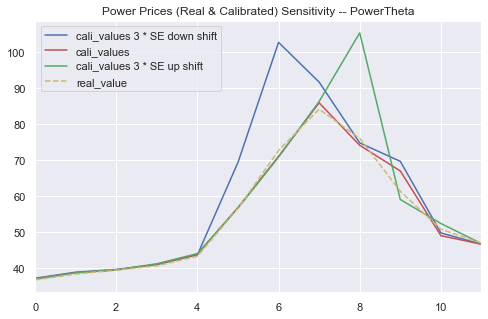

In [33]:
sen_test(13, multiplier, thetap1=theta_po, thetag1=theta_ga)